In [48]:
%matplotlib inline

In [49]:

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

In [50]:
def get_steps(Replay_traj, timeb=1):
    '''
    Get the levy exponent for replay trajectory
    Input 
        (dictionary): Replay_traj
        (int): time bin
    Output:
        (numpy array): all_steps for all ripple events
    
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::timeb]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

In [51]:
#log-log plot of the average step size against time bins
def get_diffusion_exponent(Replay_traj, plot=False, get_intercept=False): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    all_std_steps = []
    for timeb in all_timebins:
        all_steps = get_steps(Replay_traj, timeb)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        std_step = np.std(all_steps)
        
        all_avg_steps.append(avg_step)
        all_std_steps.append(std_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        #add shadow plot of the std
        #ax.fill_between(all_timebins, np.array(all_avg_steps), np.array(all_avg_steps), color='black', alpha=0.2)
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        if get_intercept:
            return fig, ax, slope, intercept
        else:
            return fig, ax, slope
    else:
        if get_intercept:
            return slope, intercept
        else:
            return slope
       

In [52]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [53]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)
    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

In [54]:
def get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running):
    """
    get the amplitude of each sweep in each theta cycle
    Input:
        lfp0_in_running: the filtered lfp in running
        sweeps_dist_in_running: the mental distance of each sweep in running
    """
    # get the zero phase index
    zero_phase_index = get_zero_phase(lfp0_in_running)
    
    #if first element in zero_phase_index is 0, remove it
    if zero_phase_index[0] == 0:
        zero_phase_index = zero_phase_index[1:]

    # split the sweeps_dist_in_running according to the zero phase index
    # and extract the largest sweep_dist in each theta cycle
    splits = np.split(sweeps_dist_in_running, zero_phase_index)

    sweep_amp_each_theta_cycle = np.array([np.max(split) for split in splits])

    #print(sweep_amp_each_theta_cycle)
    
    return np.mean(sweep_amp_each_theta_cycle)

In [55]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

## Analysis for animal bon

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Average sweep amplitude in running: 44.4201320988589


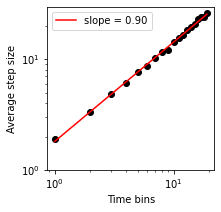

Ratio of steps that are out of two standard deviations: 0.014697876973326075
Animal: bon, Day: 3, Epoch: 4
Average sweep amplitude in running: 25.661198683610742


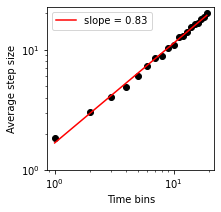

Ratio of steps that are out of two standard deviations: 0.016070222822417286
Animal: bon, Day: 3, Epoch: 6
Average sweep amplitude in running: 35.6350522926569


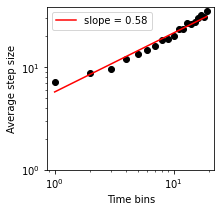

Ratio of steps that are out of two standard deviations: 0.05273933338792892
Animal: bon, Day: 4, Epoch: 2
Average sweep amplitude in running: 31.331340042096564


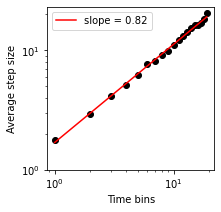

Ratio of steps that are out of two standard deviations: 0.01463860933211345
Animal: bon, Day: 4, Epoch: 4
Average sweep amplitude in running: 29.99782998886219


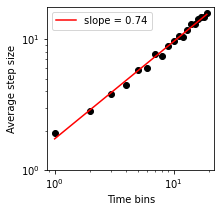

Ratio of steps that are out of two standard deviations: 0.01867881548974943
Animal: bon, Day: 4, Epoch: 6
Average sweep amplitude in running: 35.86681957297256


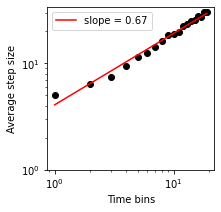

Ratio of steps that are out of two standard deviations: 0.03918507532589181
Animal: bon, Day: 5, Epoch: 2
Average sweep amplitude in running: 28.515657212304006


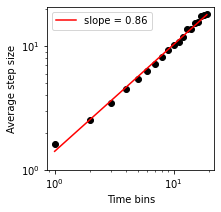

Ratio of steps that are out of two standard deviations: 0.01313522825150732
Animal: bon, Day: 5, Epoch: 4
Average sweep amplitude in running: 25.988849923496222


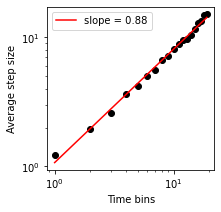

Ratio of steps that are out of two standard deviations: 0.010664123461071614
Animal: bon, Day: 5, Epoch: 6
Average sweep amplitude in running: 34.8100574457268


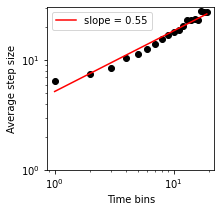

Ratio of steps that are out of two standard deviations: 0.051671087533156496
Animal: bon, Day: 6, Epoch: 2


KeyboardInterrupt: 

In [35]:

is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed =speed.values
    
    is_running = speed > 10
        
    #load lfp
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)
        
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )
    
    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)
    
    lfp0_in_running = lfp0[is_running]

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    mean_sweep_amp = get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running)
    print(f'Average sweep amplitude in running: {mean_sweep_amp}')
    
    sweep_len1.append(mean_sweep_amp)
    
    #remove those values more than 30 in sweeps_dist_in_running
    #sweeps_dist_in_running = sweeps_dist_in_running.where(sweeps_dist_in_running<30)
    
    #find all the local peaks in sweeps_dist_in_running and average all the peaks 

        
    # #print the average sweep length
    # print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    # sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    fig, ax, slope = get_diffusion_exponent(Replay_traj, plot=True)
    exponent1.append(slope)
    #show the plot
    plt.show()
    
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

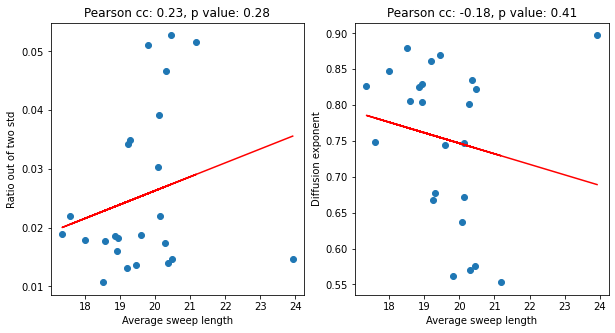

In [128]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()
    

In [ ]:
is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len0 = []
replay_ratio0 = []
exponent0 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    sweep_len0.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent0.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio0.append(ratio)
        
        

In [ ]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len0), np.array(replay_ratio0))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(replay_ratio0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(replay_ratio0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len0), np.array(exponent0))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(exponent0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(exponent0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Analysis for animal con

In [ ]:
is_animal = epoch_info.index.isin(['con'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
ave_speed1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed1.append(mean_speed)
    
    sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent1.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

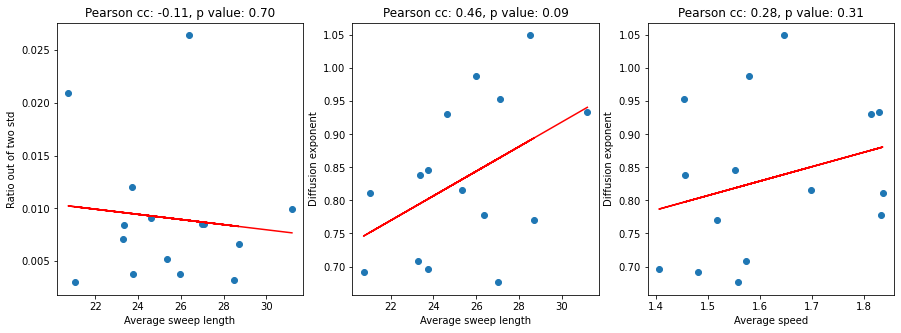

In [20]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed1), np.array(exponent1))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed1), np.array(exponent1), 1)
plt.plot(np.array(ave_speed1), np.array(ave_speed1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Get theta sweep and replay results for one animal

In [56]:
def get_sweep_and_replay_results(epoch_key, datadir, sweep_speed_threshold=4):
    '''
    Get the average sweep length and replay exponent for one epoch
    '''
    animal, day, epoch = epoch_key
    
    #1, LOAD THETA SWEEPS RESULTS
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
    
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > sweep_speed_threshold

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]
    
    #get mean speed with speed < 4 (mean speed udring immobile state)
    mean_immobile_speed = np.mean(speed[speed<4])
    
    mean_sweep_dist = np.mean(sweeps_dist_in_running).values
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(datadir, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    replay_exponent, replay_intercept = get_diffusion_exponent(Replay_traj, plot=False, get_intercept=True)
        
    return mean_immobile_speed, mean_sweep_dist, replay_exponent, replay_intercept
    

In [10]:
is_animal = epoch_info.index.isin(['cha'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len = []
exponent = []
ave_speed = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #get the average sweep length and replay exponent
    mean_immobile_speed, mean_sweep_dist, replay_exponent, replay_intercept = get_sweep_and_replay_results(epoch_key, DATA_DIR)

    #print the average sweep length and replay exponent in one line, keep three decimal places
    print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')

    ave_speed.append(mean_immobile_speed)
    sweep_len.append(mean_sweep_dist)
    exponent.append(replay_exponent)

        

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2


epochs:  25%|██▌       | 1/4 [00:04<00:13,  4.52s/it]

Average sweep length: 50.093, Diffusion exponent: 0.727
Animal: cha, Day: 4, Epoch: 4


epochs:  50%|█████     | 2/4 [00:13<00:14,  7.18s/it]

Average sweep length: 46.601, Diffusion exponent: 0.583
Animal: cha, Day: 8, Epoch: 2


epochs:  75%|███████▌  | 3/4 [00:22<00:08,  8.13s/it]

Average sweep length: 50.168, Diffusion exponent: 0.572
Animal: cha, Day: 8, Epoch: 4


epochs: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]

Average sweep length: 40.948, Diffusion exponent: 0.668


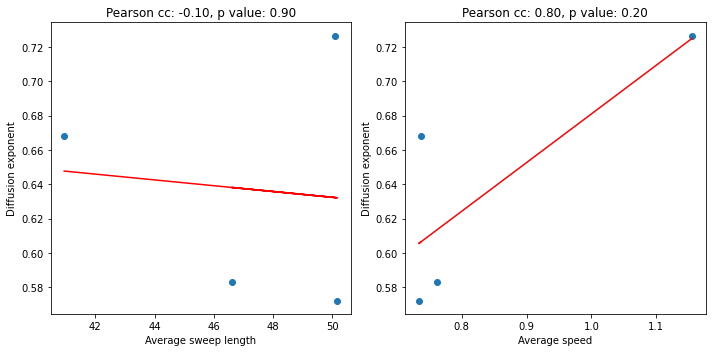

In [13]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
  
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len), np.array(exponent))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len), np.array(exponent), 1)
plt.plot(np.array(sweep_len), np.array(sweep_len)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,2,2)
plt.scatter(np.array(ave_speed), np.array(exponent))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed), np.array(exponent), 1)
plt.plot(np.array(ave_speed), np.array(ave_speed)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.tight_layout()
plt.show()

In [10]:
epoch_keys = [('remy', 35, 2), ('remy', 35, 4), ('remy', 36, 2), ('remy', 36, 4), ('remy', 37, 2), ('remy', 37, 4)]

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len = []
exponent = []
ave_speed = []
for epoch_key in epoch_keys:
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #get the average sweep length and replay exponent
    mean_immobile_speed, mean_sweep_dist, replay_exponent, replay_intercept = get_sweep_and_replay_results(epoch_key, DATA_DIR)

    #print the average sweep length and replay exponent in one line, keep three decimal places
    print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')

    ave_speed.append(mean_immobile_speed)
    sweep_len.append(mean_sweep_dist)
    exponent.append(replay_exponent)

Animal: remy, Day: 35, Epoch: 2
Average sweep length: 101.232, Diffusion exponent: -0.016
Animal: remy, Day: 35, Epoch: 4
Average sweep length: 94.304, Diffusion exponent: 0.018
Animal: remy, Day: 36, Epoch: 2
Average sweep length: 100.920, Diffusion exponent: 0.021
Animal: remy, Day: 36, Epoch: 4
Average sweep length: 99.188, Diffusion exponent: -0.002
Animal: remy, Day: 37, Epoch: 2
Average sweep length: 98.450, Diffusion exponent: 0.053
Animal: remy, Day: 37, Epoch: 4
Average sweep length: 32.733, Diffusion exponent: 0.516


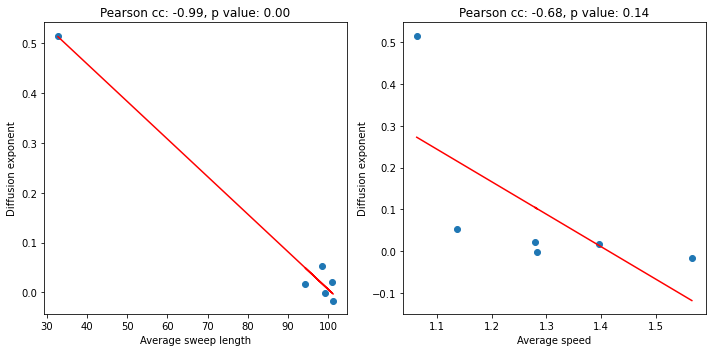

In [13]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
  
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len), np.array(exponent))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len), np.array(exponent), 1)
plt.plot(np.array(sweep_len), np.array(sweep_len)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,2,2)
plt.scatter(np.array(ave_speed), np.array(exponent))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed), np.array(exponent), 1)
plt.plot(np.array(ave_speed), np.array(ave_speed)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed), np.array(exponent))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.tight_layout()
plt.show()

In [30]:
#load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
with open(os.path.join('/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories', f'remy_37_04_traj.pkl'), 'rb') as f:
    Replay_traj = pickle.load(f)
 
#check the maximum and minumum value in each trajectory value
max_value = []; min_value = []
for traj in Replay_traj.keys():
    max_value.append(np.max(Replay_traj[traj]))
    min_value.append(np.min(Replay_traj[traj]))
max_value

[195.80064819654666,
 195.80064819654666,
 195.80064819654666,
 195.80064819654666,
 195.80064819654666,
 80.42923818822904,
 172.02886282033657,
 195.80064819654666,
 151.9174031053543,
 195.80064819654666,
 121.51381889589011,
 172.02886282033657,
 193.10483827572364,
 195.80064819654666,
 13.17344856984286,
 193.10483827572364,
 193.10483827572364,
 45.37521174056984,
 195.80064819654666,
 1.4637165077603176,
 1.4637165077603176,
 1.4637165077603176,
 10.246015554322224,
 62.93980983369365,
 16.100881585363496,
 195.80064819654666,
 193.10483827572364,
 1.4637165077603176,
 195.80064819654666,
 193.10483827572364,
 193.10483827572364,
 195.80064819654666,
 1.4637165077603176,
 193.10483827572364,
 193.10483827572364,
 195.80064819654666,
 193.10483827572364,
 195.80064819654666,
 42.4477787250492,
 1.4637165077603176,
 172.02886282033657,
 186.88622868046792,
 195.80064819654666,
 193.10483827572364,
 195.80064819654666,
 1.4637165077603176,
 113.75436064835284,
 178.39504000059173,

In [31]:
min_value

[80.42923818822904,
 88.76051880325997,
 13.17344856984286,
 33.665479678487294,
 195.80064819654666,
 51.23007777161111,
 1.4637165077603176,
 169.05738964831033,
 48.30264475609047,
 148.97544345032793,
 121.51381889589011,
 94.31470587994727,
 19.02831460088413,
 195.80064819654666,
 1.4637165077603176,
 1.4637165077603176,
 193.1048382757236,
 42.4477787250492,
 195.80064819654666,
 1.4637165077603176,
 1.4637165077603176,
 1.4637165077603176,
 10.246015554322224,
 10.246015554322224,
 1.4637165077603176,
 4.391149523280953,
 193.10483827572364,
 1.4637165077603176,
 108.20017357166553,
 193.10483827572364,
 1.4637165077603176,
 195.80064819654666,
 1.4637165077603176,
 1.4637165077603176,
 193.10483827572364,
 163.68524172545983,
 193.10483827572364,
 1.4637165077603176,
 24.883180631925388,
 1.4637165077603176,
 10.246015554322224,
 13.17344856984286,
 148.97544345032793,
 193.10483827572364,
 1.4637165077603176,
 1.4637165077603176,
 1.4637165077603176,
 27.810613647446022,
 1.4

## Analysis for all animals

In [57]:
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )

    # #add remy 37 4 to the valid_epochs since this is the only valid epoch for remy. 
    # #generally data for remy was stored differently from other animals
    # valid_epochs[('remy', 37, 4)] = True
    
    sweep_len = []
    exponent = []
    intercept = []
    ave_speed = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        #get the average sweep length and replay exponent
        mean_immobile_speed, mean_sweep_dist, replay_exponent, replay_intercept = get_sweep_and_replay_results(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        
        ave_speed.append(mean_immobile_speed)
        sweep_len.append(mean_sweep_dist)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_sweep_len_peranimal[name] = sweep_len
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Average sweep length: 28.694, Diffusion exponent: 0.836
Animal: bon, Day: 3, Epoch: 4
Average sweep length: 15.452, Diffusion exponent: 0.840
Animal: bon, Day: 3, Epoch: 6
Average sweep length: 22.764, Diffusion exponent: 0.476
Animal: bon, Day: 4, Epoch: 2
Average sweep length: 18.438, Diffusion exponent: 0.838
Animal: bon, Day: 4, Epoch: 4
Average sweep length: 17.515, Diffusion exponent: 0.759
Animal: bon, Day: 4, Epoch: 6
Average sweep length: 26.638, Diffusion exponent: 0.643
Animal: bon, Day: 5, Epoch: 2
Average sweep length: 15.255, Diffusion exponent: 0.751
Animal: bon, Day: 5, Epoch: 4
Average sweep length: 14.941, Diffusion exponent: 0.756
Animal: bon, Day: 5, Epoch: 6
Average sweep length: 24.863, Diffusion exponent: 0.616
Animal: bon, Day: 6, Epoch: 2
Average sweep length: 18.539, Diffusion exponent: 0.748
Animal: bon, Day: 6, Epoch: 4
Average sweep length: 15.474, Diffusion exponent: 0.661
Animal: bon, Day: 6, Epoch: 6
Average sweep length: 23

epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 4, Epoch: 2
Average sweep length: 20.092, Diffusion exponent: 0.813
Animal: fra, Day: 4, Epoch: 4
Average sweep length: 17.059, Diffusion exponent: 0.755
Animal: fra, Day: 4, Epoch: 6
Average sweep length: 18.628, Diffusion exponent: 0.570
Animal: fra, Day: 5, Epoch: 2
Average sweep length: 29.320, Diffusion exponent: 0.723
Animal: fra, Day: 5, Epoch: 4
Average sweep length: 22.498, Diffusion exponent: 0.748
Animal: fra, Day: 5, Epoch: 6
Average sweep length: 17.249, Diffusion exponent: 0.652
Animal: fra, Day: 6, Epoch: 2
Average sweep length: 20.728, Diffusion exponent: 0.775
Animal: fra, Day: 6, Epoch: 4
Average sweep length: 19.103, Diffusion exponent: 0.802
Animal: fra, Day: 6, Epoch: 6
Average sweep length: 15.996, Diffusion exponent: 0.559
Animal: fra, Day: 7, Epoch: 2
Average sweep length: 17.274, Diffusion exponent: 0.778
Animal: fra, Day: 7, Epoch: 4
Average sweep length: 15.934, Diffusion exponent: 0.735
Animal: fra, Day: 7, Epoch: 6
Average sweep length: 16

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2
Average sweep length: 42.181, Diffusion exponent: 0.770
Animal: gov, Day: 6, Epoch: 4
Average sweep length: 38.538, Diffusion exponent: 0.834
Animal: gov, Day: 6, Epoch: 6
Average sweep length: 31.102, Diffusion exponent: 0.765
Animal: gov, Day: 7, Epoch: 2
Average sweep length: 30.097, Diffusion exponent: 0.792
Animal: gov, Day: 7, Epoch: 4
Average sweep length: 23.374, Diffusion exponent: 0.771
Animal: gov, Day: 7, Epoch: 6
Average sweep length: 32.112, Diffusion exponent: 0.857
Animal: gov, Day: 8, Epoch: 2
Average sweep length: 27.411, Diffusion exponent: 0.782
Animal: gov, Day: 8, Epoch: 4
Average sweep length: 24.466, Diffusion exponent: 0.810
Animal: gov, Day: 8, Epoch: 6
Average sweep length: 31.787, Diffusion exponent: 0.662
Animal: gov, Day: 9, Epoch: 2
Average sweep length: 40.371, Diffusion exponent: 0.772
Animal: gov, Day: 9, Epoch: 3
Average sweep length: 24.728, Diffusion exponent: 0.713
Animal: gov, Day: 9, Epoch: 5
Average sweep length: 34

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2
Average sweep length: 51.268, Diffusion exponent: 0.792
Animal: dud, Day: 5, Epoch: 2
Average sweep length: 41.509, Diffusion exponent: 0.810


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2
Average sweep length: 29.336, Diffusion exponent: 0.803
Animal: con, Day: 1, Epoch: 4
Average sweep length: 21.269, Diffusion exponent: 0.903
Animal: con, Day: 2, Epoch: 2
Average sweep length: 25.001, Diffusion exponent: 1.084
Animal: con, Day: 2, Epoch: 4
Average sweep length: 22.739, Diffusion exponent: 0.931
Animal: con, Day: 3, Epoch: 2
Average sweep length: 26.488, Diffusion exponent: 0.955
Animal: con, Day: 3, Epoch: 4
Average sweep length: 20.019, Diffusion exponent: 0.953
Animal: con, Day: 4, Epoch: 2
Average sweep length: 25.689, Diffusion exponent: 0.629
Animal: con, Day: 4, Epoch: 4
Average sweep length: 22.011, Diffusion exponent: 0.902
Animal: con, Day: 4, Epoch: 6
Average sweep length: 19.763, Diffusion exponent: 0.602
Animal: con, Day: 5, Epoch: 2
Average sweep length: 21.089, Diffusion exponent: 0.914
Animal: con, Day: 5, Epoch: 4
Average sweep length: 19.997, Diffusion exponent: 0.767
Animal: con, Day: 5, Epoch: 6
Average sweep length: 22

epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 2
Average sweep length: 37.958, Diffusion exponent: 0.864
Animal: dav, Day: 3, Epoch: 4
Average sweep length: 31.233, Diffusion exponent: 0.761
Animal: dav, Day: 3, Epoch: 6
Average sweep length: 33.076, Diffusion exponent: 0.865
Animal: dav, Day: 4, Epoch: 2
Average sweep length: 45.286, Diffusion exponent: 0.811
Animal: dav, Day: 4, Epoch: 4
Average sweep length: 28.193, Diffusion exponent: 0.860
Animal: dav, Day: 4, Epoch: 6
Average sweep length: 26.897, Diffusion exponent: 0.812
Animal: dav, Day: 5, Epoch: 3
Average sweep length: 37.314, Diffusion exponent: 0.823
Animal: dav, Day: 6, Epoch: 2
Average sweep length: 32.341, Diffusion exponent: 0.781
Animal: dav, Day: 6, Epoch: 4
Average sweep length: 22.005, Diffusion exponent: 0.911
Animal: dav, Day: 6, Epoch: 6
Average sweep length: 27.046, Diffusion exponent: 0.752
Animal: dav, Day: 7, Epoch: 2
Average sweep length: 27.716, Diffusion exponent: 0.810
Animal: dav, Day: 7, Epoch: 3
Average sweep length: 27

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 2
Average sweep length: 47.554, Diffusion exponent: 0.781
Animal: Cor, Day: 1, Epoch: 4
Average sweep length: 26.151, Diffusion exponent: 0.863
Animal: Cor, Day: 2, Epoch: 2
Average sweep length: 27.537, Diffusion exponent: 0.774
Animal: Cor, Day: 2, Epoch: 4
Average sweep length: 25.822, Diffusion exponent: 0.703
Animal: Cor, Day: 3, Epoch: 2
Average sweep length: 27.993, Diffusion exponent: 0.745
Animal: Cor, Day: 3, Epoch: 4
Average sweep length: 23.716, Diffusion exponent: 0.816
Animal: Cor, Day: 4, Epoch: 2
Average sweep length: 27.034, Diffusion exponent: 0.798
Animal: Cor, Day: 4, Epoch: 4
Average sweep length: 70.488, Diffusion exponent: 0.780
Animal: Cor, Day: 7, Epoch: 2
Average sweep length: 24.679, Diffusion exponent: 0.807
Animal: Cor, Day: 8, Epoch: 2
Average sweep length: 32.787, Diffusion exponent: 0.730


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2
Average sweep length: 30.278, Diffusion exponent: 0.800
Animal: egy, Day: 5, Epoch: 4
Average sweep length: 26.949, Diffusion exponent: 0.868
Animal: egy, Day: 5, Epoch: 6
Average sweep length: 29.352, Diffusion exponent: 0.730
Animal: egy, Day: 6, Epoch: 4
Average sweep length: 38.525, Diffusion exponent: 0.856
Animal: egy, Day: 6, Epoch: 7
Average sweep length: 33.940, Diffusion exponent: 0.805
Animal: egy, Day: 7, Epoch: 2
Average sweep length: 38.709, Diffusion exponent: 0.810
Animal: egy, Day: 7, Epoch: 4
Average sweep length: 34.899, Diffusion exponent: 0.826
Animal: egy, Day: 7, Epoch: 6
Average sweep length: 53.380, Diffusion exponent: 0.805
Animal: egy, Day: 8, Epoch: 2
Average sweep length: 37.534, Diffusion exponent: 0.848
Animal: egy, Day: 8, Epoch: 4
Average sweep length: 48.738, Diffusion exponent: 0.775
Animal: egy, Day: 8, Epoch: 6
Average sweep length: 31.795, Diffusion exponent: 0.868
Animal: egy, Day: 9, Epoch: 2
Average sweep length: 44

epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2
Average sweep length: 50.093, Diffusion exponent: 0.727
Animal: cha, Day: 4, Epoch: 4
Average sweep length: 46.601, Diffusion exponent: 0.583
Animal: cha, Day: 8, Epoch: 2
Average sweep length: 50.168, Diffusion exponent: 0.572
Animal: cha, Day: 8, Epoch: 4
Average sweep length: 40.948, Diffusion exponent: 0.668


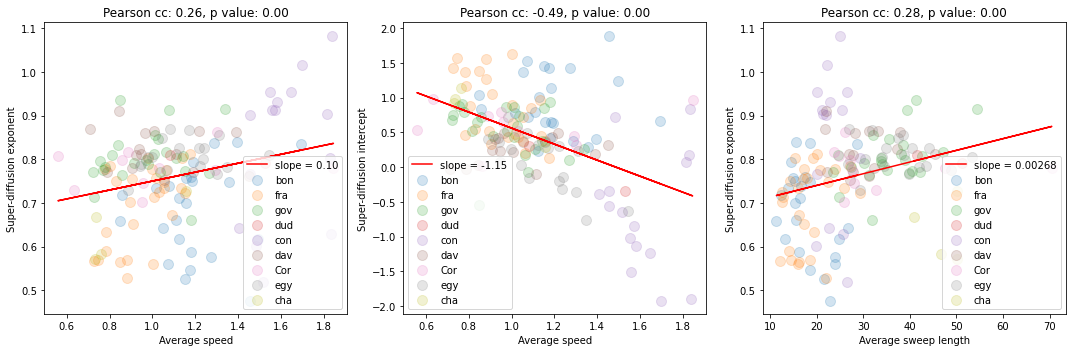

In [59]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_peranimal, all_sweep_len_peranimal, all_exponent_peranimal here

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_peranimal[name]), np.array(all_exponent_peranimal[name]), label=name, s=100, alpha=0.2)
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_speed_np = np.concatenate(list(all_ave_speed_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_speed_np, all_exp_np, 1)
plt.plot(all_speed_np, all_speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(all_speed_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion exponent')
plt.legend()

#intercept
plt.subplot(1,3,2)
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_peranimal[name]), np.array(all_intercept_peranimal[name]), label=name, s=100, alpha=0.2)
all_intercept_np = np.concatenate(list(all_intercept_peranimal.values()))
all_speed_np = np.concatenate(list(all_ave_speed_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_speed_np, all_intercept_np, 1)
plt.plot(all_speed_np, all_speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(all_speed_np, all_intercept_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion intercept')
plt.legend()

plt.subplot(1,3,3)
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_peranimal[name]), np.array(all_exponent_peranimal[name]), label=name, s=100, alpha=0.2)
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_sweep_len_np = np.concatenate(list(all_sweep_len_peranimal.values()))
#add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_sweep_len_np, all_exp_np, 1)
plt.plot(all_sweep_len_np, all_sweep_len_np*slope+intercept, 'r-', label='slope = %.5f'%slope)
#pearson test
corr, p = pearsonr(all_sweep_len_np, all_exp_np)
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average sweep length')
plt.ylabel('Super-diffusion exponent')
plt.legend()

plt.tight_layout()



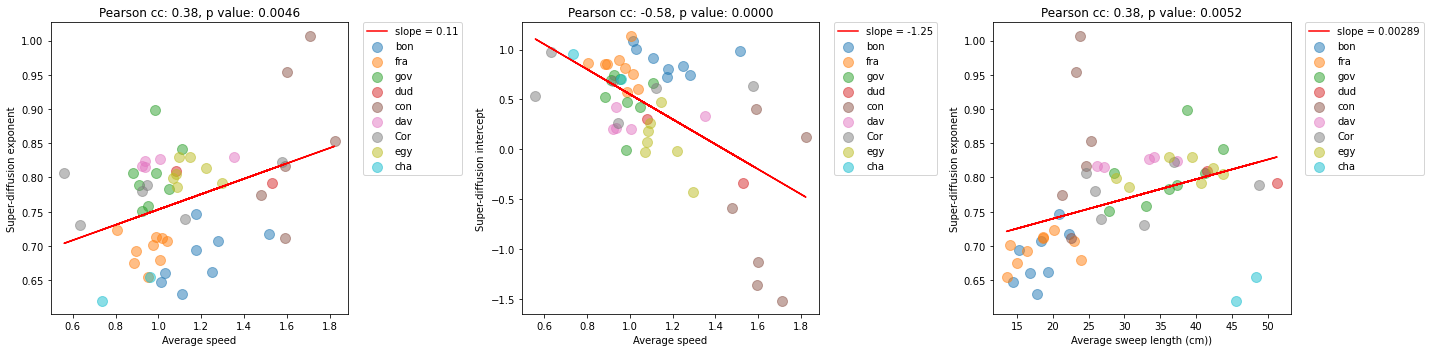

In [60]:
#plot ave_speed against replay_exponent for each animal, each with different color in subplot 1
#plot sweep_len against replay_exponent for each animal, each with different color in subplot 2
#using all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday here

#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_peranimal = {}

#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday
all_ave_speed_perday_ave = {}
all_sweep_len_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_sweep_len_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.5, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)

#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#intercept
plt.subplot(1,3,2)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.5, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'r-', label='slope = %.2f'%slope)

#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed')
plt.ylabel('Super-diffusion intercept')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(1,3,3)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.5, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'r-', label='slope = %.5f'%slope)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Super-diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


